# Plot sam_sim

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:Using config from /home/jchaves/Proyectos/projects/lya/cup1d/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

/home/jchaves/Proyectos/projects/lya/cup1d/notebooks/


## Read Data

### Options

In [2]:
from cup1d.scripts.call_max_like_sim import Args
from cup1d.scripts.sam_sim import path_sampler
from matplotlib.ticker import MaxNLocator
from lace.archive import gadget_archive, nyx_archive
from cup1d.likelihood import lya_theory
from lace.cosmo.camb_cosmo import (
    get_camb_results,
    get_Nyx_cosmology,
    get_cosmology_from_dictionary,
)
from lace.cosmo.fit_linP import parameterize_cosmology_kms
from cup1d.likelihood import CAMB_model

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


#### check data

In [3]:
def check_data(mock_sim, igm_sim, cosmo_sim):
    folder0 = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/v1/Cabayol23_lres/"
    folder1 = f"emu_Cabayol23_cov_Chabanier2019_mocksim_{mock_sim}_cosmosim_{cosmo_sim}_igmsim_{igm_sim}_nigm_2_ydrop_ypoly/"
    name = folder0 + folder1 + "chain_1/results.npy"
    #     print(name)
    try:
        results = np.load(name, allow_pickle=True).item()
    except:
        print(name)

In [4]:
sim_label_cen = "mpg_central"
sim_labs = []
for isim in range(30):
    sim_label = "mpg_" + str(isim)
    sim_labs.append(sim_label)
    for opt in range(4):
        if opt == 0:
            dat = check_data(sim_label, sim_label, sim_label)
        elif opt == 1:
            dat = check_data(sim_label, sim_label, sim_label_cen)
        elif opt == 2:
            dat = check_data(sim_label, sim_label_cen, sim_label)
        elif opt == 3:
            dat = check_data(sim_label, sim_label_cen, sim_label_cen)

### get data

In [5]:
def get_data(mock_sim, igm_sim, cosmo_sim):
    folder0 = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/v1/Cabayol23_lres/"
    folder1 = f"emu_Cabayol23_cov_Chabanier2019_mocksim_{mock_sim}_cosmosim_{cosmo_sim}_igmsim_{igm_sim}_nigm_2_ydrop_ypoly/"
    name = folder0 + folder1 + "chain_1/results.npy"
    #     print(name)
    try:
        results = np.load(name, allow_pickle=True).item()
    except:
        print(name)
        raise
    return results

Mock, IGM, Cosmo
- L1O, L1O, L1O
- L1O, L1O, CEN
- L1O, CEN, L1O
- L1O, CEN, CEN

In [7]:
par_get = ["$\\Delta^2_\\star$", "$n_\\star$"]
sim_labs = []

lio_true = np.zeros((30, len(par_get)))
lio_best = np.zeros((30, 4, len(par_get), 3))
sim_label_cen = "mpg_central"
for isim in range(30):
    sim_label = "mpg_" + str(isim)
    sim_labs.append(sim_label)
    for opt in range(4):
        if opt == 0:
            dat = get_data(sim_label, sim_label, sim_label)
        elif opt == 1:
            dat = get_data(sim_label, sim_label, sim_label_cen)
        elif opt == 2:
            dat = get_data(sim_label, sim_label_cen, sim_label)
        elif opt == 3:
            dat = get_data(sim_label, sim_label_cen, sim_label_cen)
        ii0 = 0
        for ii, par in enumerate(dat["param_names"]):
            if par in par_get:
                if opt == 0:
                    lio_true[isim, ii0] = dat["truth"][par]
                lio_best[isim, opt, ii0] = dat["param_percen"][ii]
                ii0 += 1
sim_labs = np.array(sim_labs)

In [45]:
dat_cen = get_data(sim_label_cen, sim_label_cen, sim_label_cen)

### Plot data

In [43]:
def plot_lio(
    out_folder, sim_labs, par_labs, truth, best, type_plot="both", index=0
):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

    for ipar in range(truth.shape[1]):
        if ipar == 0:
            label0 = "Best"
            label1 = "Truth"
            if type_plot == "both":
                ylima = 0.19
                ylimb = 0.61
            else:
                ylima = -40
                ylimb = 40
        else:
            label0 = None
            label1 = None
            if type_plot == "both":
                ylima = -2.41
                ylimb = -2.19
            else:
                ylima = -2.5
                ylimb = 2.5

        y_best = best[:, ipar, 1]
        y_err = np.abs(best[:, ipar, np.array([0, 2])] - y_best[:, None]).T
        y_true = truth[:, ipar]

        if type_plot == "both":
            ax[ipar].errorbar(
                sim_labs,
                y_best,
                yerr=y_err,
                color="C0",
                ls="",
                marker="o",
                label=label0,
                alpha=0.5,
            )

            ax[ipar].plot(
                sim_labs,
                y_true,
                ls="",
                color="C1",
                marker="x",
                label=label1,
            )

            if ipar == 0:
                ax[ipar].legend()
            ax[ipar].set_ylabel(par_labs[ipar])
        else:
            ax[ipar].errorbar(
                sim_labs,
                (y_best / y_true - 1) * 100,
                yerr=y_err / np.abs(y_true) * 100,
                color="C0",
                ls="",
                marker="o",
                label=label0,
            )
            ax[ipar].axhline(0, ls=":", color="k", alpha=0.5)
            ax[ipar].set_ylabel(r"$\Delta$(" + par_labs[ipar] + ")[%]")
        ax[ipar].set_ylim(ylima, ylimb)
        plt.xticks(rotation=45, ha="right")

    if index == 0:
        tit = "Mock L1O, IGM L1O, Cosmo L1O"
    elif index == 1:
        tit = "Mock L1O, IGM L1O, Cosmo central"
    elif index == 2:
        tit = "Mock L1O, IGM central, Cosmo L1O"
    elif index == 3:
        tit = "Mock L1O, IGM central, Cosmo central"
    if type_plot == "both":
        msg = "Best-fitting solution and truth"
    else:
        msg = "Percentage difference between best-fitting solution and truth"

    plt.suptitle(tit + "\n\n" + msg)
    plt.tight_layout()

    folds = ["", "pdf/", "png/"]
    for ii, fold in enumerate(folds):
        _out_folder = out_folder + fold
        if not os.path.exists(_out_folder):
            os.makedirs(_out_folder)
        if ii == 1:
            fname = (
                _out_folder + "lio_" + type_plot + "_" + str(index) + ".pdf"
            )
            plt.savefig(fname)
        elif ii == 2:
            fname = (
                _out_folder + "lio_" + type_plot + "_" + str(index) + ".png"
            )
            plt.savefig(fname)

<IPython.core.display.Javascript object>


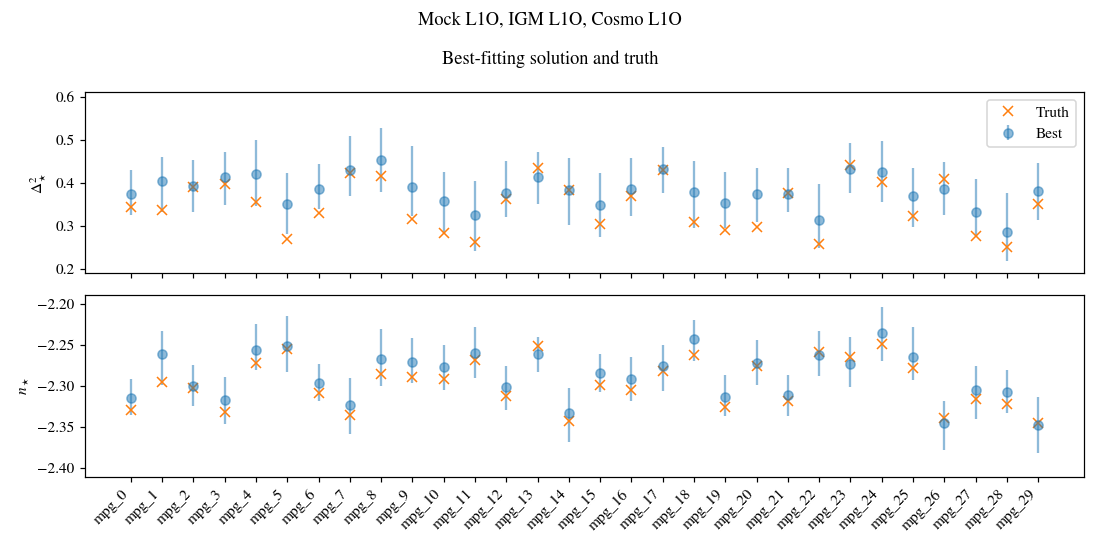

<IPython.core.display.Javascript object>


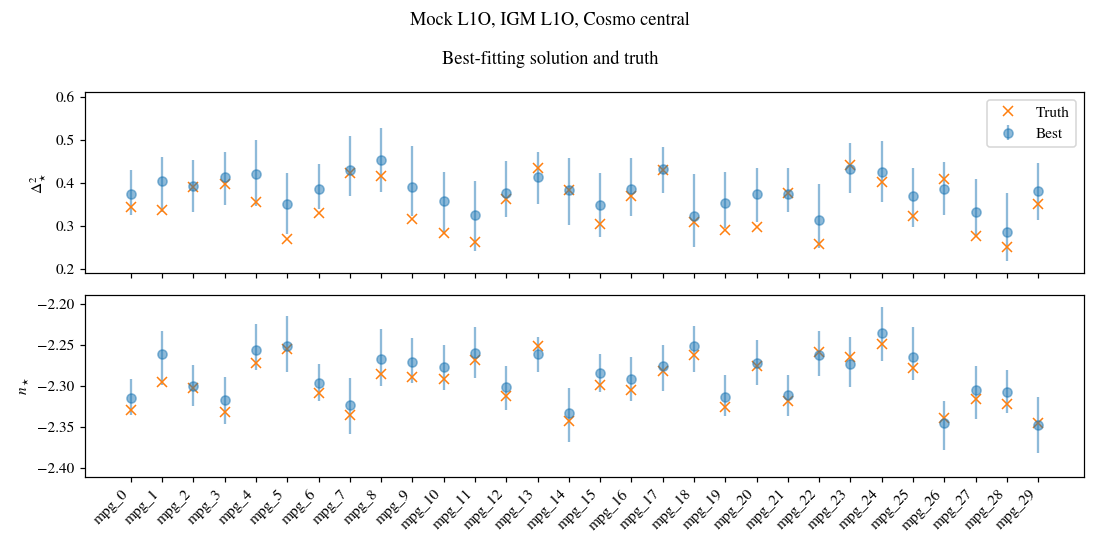

<IPython.core.display.Javascript object>


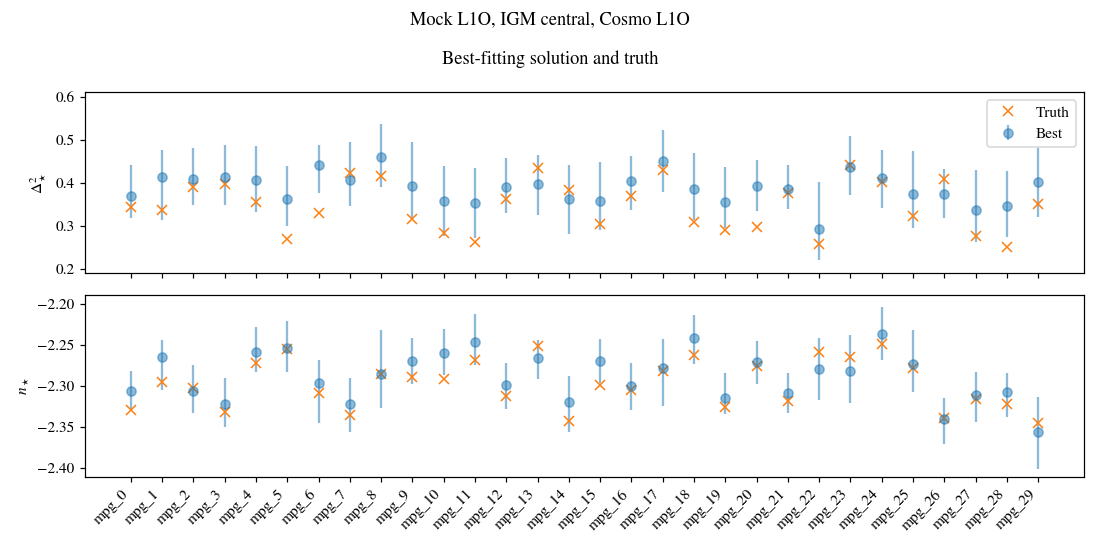

<IPython.core.display.Javascript object>


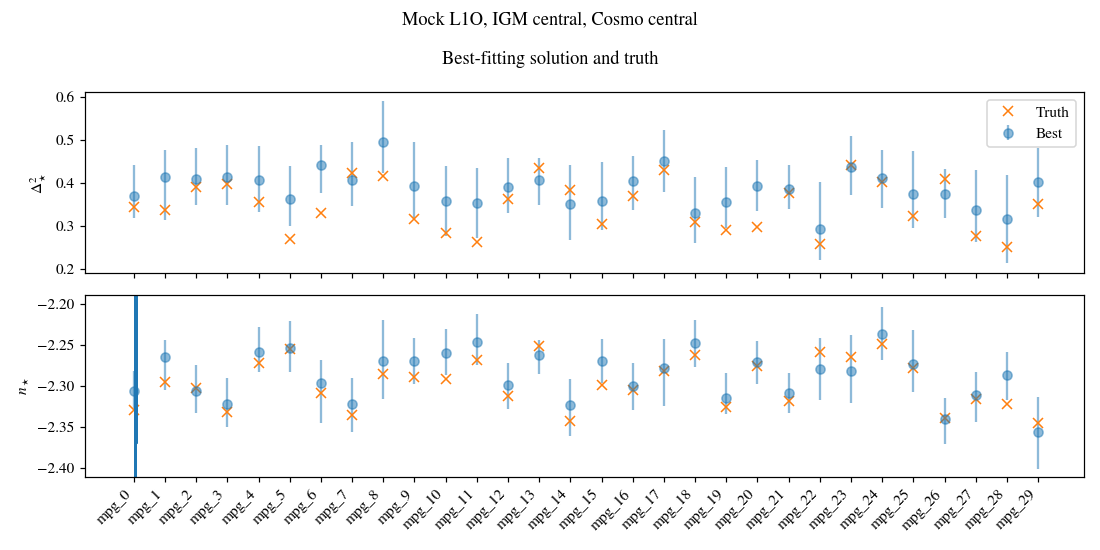

In [44]:
out_folder = (
    os.environ["LYA_DATA_PATH"] + "/cup1d/sampler/v1/figs_Cabayol23_lres/"
)
for index in range(4):
    plot_lio(
        out_folder,
        sim_labs,
        par_get,
        lio_true,
        lio_best[:, index],
        type_plot="both",
        index=index,
    )

### Distance convex hull

<IPython.core.display.Javascript object>


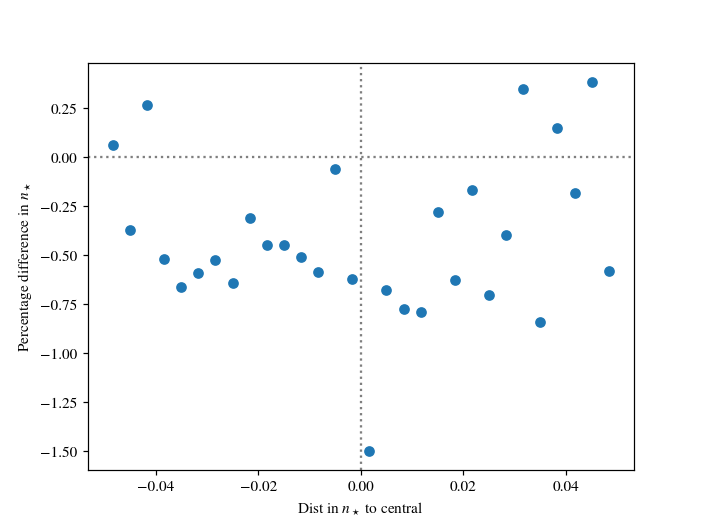

Text(0, 0.5, 'Percentage difference in $n_\\star$')

In [67]:
flags = ["$\\Delta^2_\\star$", "$n_\\star$"]

ipar = iuse = 1
dist = lio_true[:, ipar] - dat_cen["truth"][flags[ipar]]
precision = (lio_best[:, 0, iuse, 1] / lio_true[:, iuse] - 1) * 100

plt.axhline(0, ls=":", color="k", alpha=0.5)
plt.axvline(0, ls=":", color="k", alpha=0.5)
plt.scatter(dist, precision)
plt.xlabel("Dist in " + flags[ipar] + " to central")
plt.ylabel("Percentage difference in " + flags[ipar])

One way

<IPython.core.display.Javascript object>


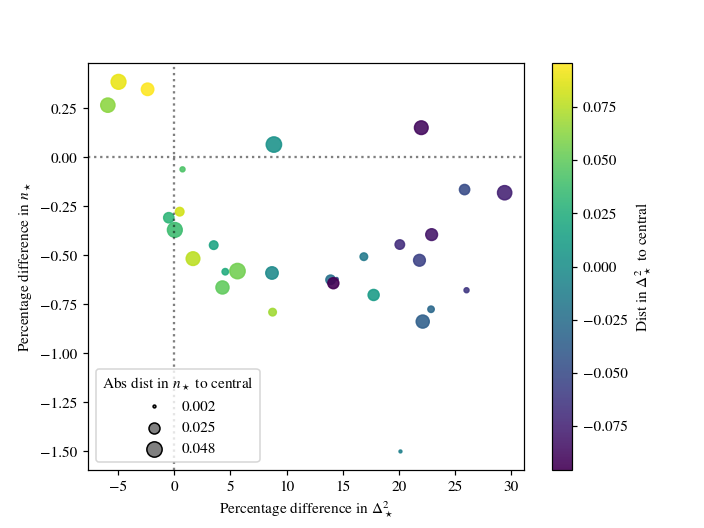

Text(0, 0.5, 'Percentage difference in $n_\\star$')

In [109]:
flags = ["$\\Delta^2_\\star$", "$n_\\star$"]

dist_max_0 = np.max(lio_true[:, 0]) - np.min(lio_true[:, 0])
dist_max_1 = np.max(lio_true[:, 1]) - np.min(lio_true[:, 1])

dist0 = lio_true[:, 0] - dat_cen["truth"][flags[0]]
scaling = 200
dist1 = (
    np.abs(lio_true[:, 1] - dat_cen["truth"][flags[1]]) / dist_max_1 * scaling
)

iuse = 0
precision0 = (lio_best[:, 0, iuse, 1] / lio_true[:, iuse] - 1) * 100
iuse = 1
precision1 = (lio_best[:, 0, iuse, 1] / lio_true[:, iuse] - 1) * 100

# plt.axhline(0, ls=":", color="k", alpha=0.5)
# plt.axvline(0, ls=":", color="k", alpha=0.5)
plt.scatter(precision0, precision1, c=dist0, s=dist1, alpha=0.9)
plt.colorbar(label="Dist in " + flags[0] + " to central")

sizes = np.linspace(
    dist1.min(), dist1.max(), 3
)  # Define marker sizes for the legend
legend_labels = [
    str(np.round(size / scaling * dist_max_1, 3)) for size in sizes
]

proxy_artists = [
    plt.scatter([], [], s=size, label=label, color="gray", edgecolor="black")
    for size, label in zip(sizes, legend_labels)
]

# Add legend
plt.legend(
    handles=proxy_artists,
    title="Abs dist in " + flags[1] + " to central",
    loc="lower left",
)

plt.axhline(0, ls=":", color="k", alpha=0.5)
plt.axvline(0, ls=":", color="k", alpha=0.5)


# plt.xlabel("Dist in " + flags[ipar] + " to central")
plt.xlabel("Percentage difference in " + flags[0])
plt.ylabel("Percentage difference in " + flags[1])

The other

<IPython.core.display.Javascript object>


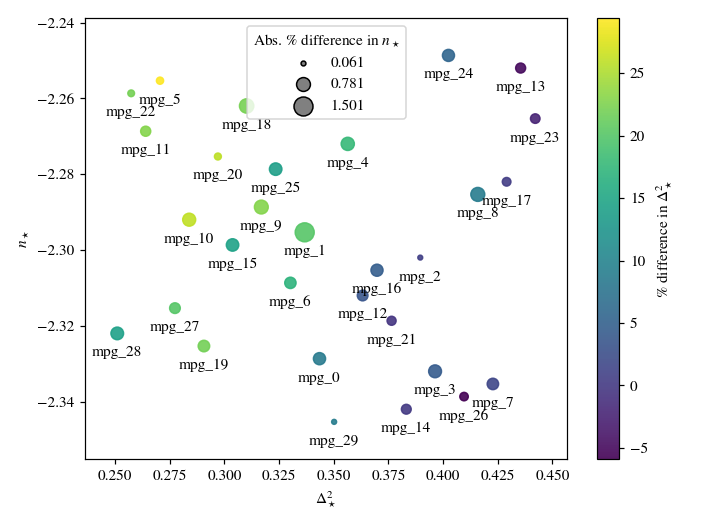

In [150]:
flags = ["$\\Delta^2_\\star$", "$n_\\star$"]

dist_max_0 = np.max(lio_true[:, 0]) - np.min(lio_true[:, 0])
dist_max_1 = np.max(lio_true[:, 1]) - np.min(lio_true[:, 1])

dist0 = lio_true[:, 0].copy()
dist1 = lio_true[:, 1].copy()

iuse = 0
precision0 = (lio_best[:, 0, iuse, 1] / lio_true[:, iuse] - 1) * 100
iuse = 1
precision1 = np.abs(lio_best[:, 0, iuse, 1] / lio_true[:, iuse] - 1) * 100
precision1b = (precision1 - np.min(precision1)) * 100 + 10

xlab = flags[0]
ylab = flags[1]
clab = "% difference in " + flags[0]
slab = "Abs. % difference in " + flags[1]

# plt.axhline(0, ls=":", color="k", alpha=0.5)
# plt.axvline(0, ls=":", color="k", alpha=0.5)
plt.scatter(dist0, dist1, c=precision0, s=precision1b, alpha=0.9)
plt.colorbar(label=clab)

for i, label in enumerate(sim_labs):
    plt.annotate(
        label,
        (dist0[i], dist1[i]),
        textcoords="offset points",
        xytext=(0, -15),
        ha="center",
    )

sizes = np.linspace(precision1b.min(), precision1b.max(), 3)
legend_labels = [
    str(np.round((size - 10) / 100 + np.min(precision1), 3)) for size in sizes
]

proxy_artists = [
    plt.scatter([], [], s=size, label=label, color="gray", edgecolor="black")
    for size, label in zip(sizes, legend_labels)
]

# Add legend
plt.legend(
    handles=proxy_artists,
    title=slab,
    loc="upper center",
)


# plt.xlabel("Dist in " + flags[ipar] + " to central")
plt.xlabel(xlab)
plt.ylabel(ylab)

plt.xlim(plt.xlim()[0] - 0.005, plt.xlim()[1] + 0.005)
plt.ylim(plt.ylim()[0] - 0.005, plt.ylim()[1] + 0.005)

plt.tight_layout()

plt.savefig(out_folder + "pdf/precision_convex_hull.pdf")
plt.savefig(out_folder + "png/precision_convex_hull.png")

In [225]:
for ii in range(20):
    plt.close()

### Mocks different seed

In [274]:
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig, ChainConfig
import pandas as pd

In [496]:
nigm = 0

In [497]:
out_folder = os.environ["LYA_DATA_PATH"] + "/cup1d/sampler/v1/Cabayol23_lres/"

In [498]:
out_folder_mocks = (
    out_folder
    + "emu_Cabayol23_cov_Chabanier2019_mocksim_mpg_central_cosmosim_mpg_central_igmsim_mpg_central_nigm_"
    + str(nigm)
    + "_ydrop_ypoly_noise_"
)

In [499]:
par_names = ["$A_s$", "$n_s$"]
# par_names = ["$\\Delta^2_\\star$", "$n_\\star$"]

In [500]:
fname = out_folder_mocks + str(0) + "/chain_1/results.npy"
summmary = np.load(fname, allow_pickle=True).item()
truth = np.array([summmary["truth"][par] for par in par_names])

In [501]:
nmocks = 10
dict_mocks = []
for ii in range(nmocks):
    fname = out_folder_mocks + str(ii) + "/chain_1/chain.npy"
    dat = np.load(fname)
    dict_mocks.append(
        {
            par_names[0]: dat[:, 0],
            par_names[1]: dat[:, 1],
        }
    )

Plot

In [502]:
import matplotlib.colors as mcolors

In [503]:
# Choose a colormap (e.g., viridis, plasma, etc.)
cmap = plt.get_cmap("rainbow")

# Linearly sample colors from the colormap
colors = cmap(np.linspace(0, 1, nmocks))

# Convert RGB colors to hexadecimal
hex_colors = [mcolors.to_hex(color) for color in colors]

In [504]:
c = ChainConsumer()

In [505]:
for ii in range(nmocks):
    # for ii in range(1):
    pd_mpg = pd.DataFrame(data=dict_mocks[ii])
    chain = Chain(
        samples=pd_mpg,
        name="Mock " + str(ii),
        linewidth=2,
        color=hex_colors[ii],
    )
    c.add_chain(chain)

In [506]:
c.add_truth(
    Truth(
        location={
            par_names[0]: truth[0],
            par_names[1]: truth[1],
        },
        line_style=":",
        color="black",
    )
)

In [520]:
c.set_override(ChainConfig(sigmas=[0, 1]))
zoom = True

if zoom:
    dt0 = truth[0] * 0.07
    dt1 = np.abs(truth[1]) * 0.025
else:
    dt0 = truth[0] * 0.6
    dt1 = np.abs(truth[1]) * 0.15
print(dt0, dt1)

c.set_plot_config(
    PlotConfig(
        extents={
            par_names[0]: (truth[0] - dt0, truth[0] + dt0),
            par_names[1]: (truth[1] - dt1, truth[1] + dt1),
        }
    )
)

1.4042385000000003e-10 0.024189125000000002


<IPython.core.display.Javascript object>


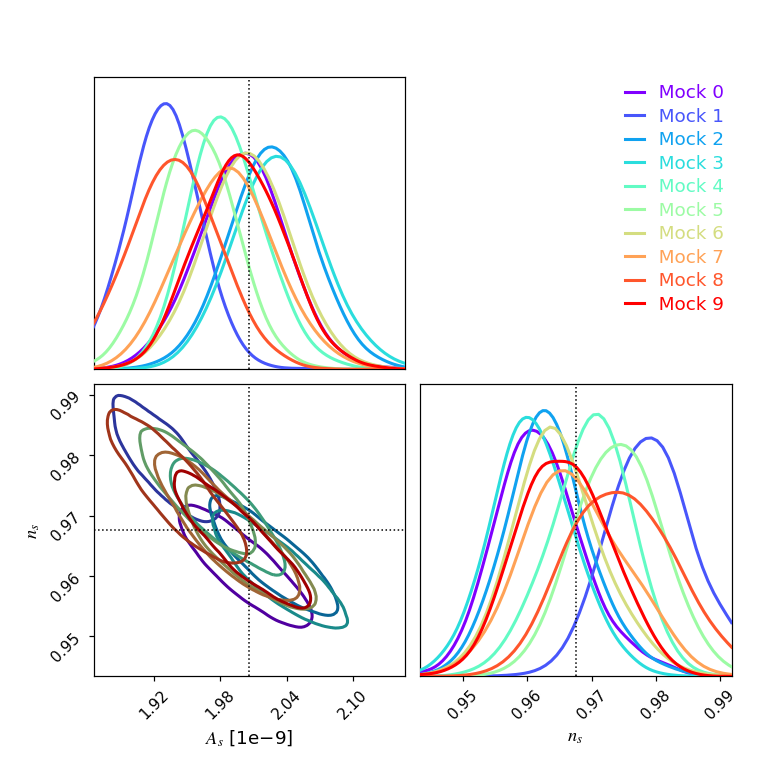

In [521]:
fig = c.plotter.plot()

In [466]:
out_folder_figs = (
    os.environ["LYA_DATA_PATH"] + "/cup1d/sampler/v1/figs_Cabayol23_lres/"
)
plt.savefig(out_folder_figs + "pdf/random_mocks_IGM" + str(nigm) + ".pdf")
plt.savefig(out_folder_figs + "png/random_mocks_IGM" + str(nigm) + ".png")

In [495]:
res_all = np.zeros((nmocks, 2, 2))
for ii in range(nmocks):
    for jj, par in enumerate(par_names):
        res_all[ii, jj, 0] = np.mean(dict_mocks[ii][par])
        res_all[ii, jj, 1] = np.std(dict_mocks[ii][par])

# plt.hist(res_all[:, 0, 0])
# plt.axvline(truth[0], ls=":", color="k")

for ii in range(2):
    print(
        np.std(res_all[:, ii, 0]),
        np.mean(res_all[:, ii, 1]),
        np.std(res_all[:, ii, 1]),
        np.round(np.mean(res_all[:, ii, 1]) / np.std(res_all[:, ii, 0]), 2),
    )

1.0441295820213295e-10 3.171669903175879e-10 4.951545065629449e-11 3.04
0.01809664662771496 0.034995878124546645 0.0035073019701222434 1.93


In [ ]:
IGM0
3.2744756825041433e-11 3.856629655504349e-11 3.0016109527442354e-12 1.18
0.005856691887705053 0.00698717585791241 0.0005660491397209245 1.19

In [ ]:
IGM1
1.437614899914239e-10 2.5750779138195933e-10 7.557662146067664e-11 1.79
0.024131774667137493 0.02892173257606394 0.004502548469268079 1.2

In [ ]:
IGM2
1.0441295820213295e-10 3.171669903175879e-10 4.951545065629449e-11 3.04
0.01809664662771496 0.034995878124546645 0.0035073019701222434 1.93

### OLD VERSION

In [3]:
def get_fid_cosmo(archive, z_star=3.0, kp_kms=0.009):
    if archive.list_sim[0][:3] == "mpg":
        get_cosmo = get_cosmology_from_dictionary
    else:
        get_cosmo = get_Nyx_cosmology
    arr_fid_cosmo = {}
    arr_fid_cosmo["Delta2_star"] = np.zeros((len(archive.list_sim)))
    arr_fid_cosmo["n_star"] = np.zeros((len(archive.list_sim)))
    for ii, sim in enumerate(archive.list_sim):
        # this simulation is problematic
        if sim != "nyx_14":
            ind = np.argwhere(archive.sim_label == sim)[0, 0]
            cosmo_fid = get_cosmo(archive.data[ind]["cosmo_params"])
            cosmo_model_fid = CAMB_model.CAMBModel(
                zs=archive.list_sim_redshifts,
                cosmo=cosmo_fid,
                z_star=z_star,
                kp_kms=kp_kms,
            )
            par = cosmo_model_fid.get_linP_params()
            arr_fid_cosmo["Delta2_star"][ii] = par["Delta2_star"]
            arr_fid_cosmo["n_star"][ii] = par["n_star"]
    return arr_fid_cosmo


def summary2array(summary, par_use):
    out = np.zeros((len(par_use), 3))
    ii = 0
    for par in file["summary"]:
        if par in par_use:
            out[ii, 0] = file["summary"][par].lower
            out[ii, 1] = file["summary"][par].center
            out[ii, 2] = file["summary"][par].upper
            ii += 1
    return out

In [13]:
# list of options to set

# training_set = "Cabayol23"
# emulator_label = "Cabayol23"
# add_hires = False
# arr_drop_sim = [True, False]
# arr_n_igm = [0, 1, 2]
# chain_lab = "chain_1"


# training_set = "Nyx23_Oct2023"
# emulator_label = "Nyx_v0"
# add_hires = False
# arr_drop_sim = [True]
# arr_n_igm = [1]
# chain_lab = "chain_1"

training_set = "Nyx23_Oct2023"
emulator_label = "Nyx_v0"
add_hires = False
arr_drop_sim = [True]
arr_n_igm = [2]
chain_lab = "chain_2"

# training_set = "Nyx23_Oct2023"
# emulator_label = "Nyx_v0_extended"
# add_hires = True
# arr_drop_sim = [True]
# arr_n_igm = [1, 2]
# chain_lab = "chain_1"

# emulator_label = "Cabayol23_extended"
# add_hires = True
use_polyfit = True
cov_label = "Chabanier2019"
override = False


if (training_set == "Pedersen21") | (training_set == "Cabayol23"):
    list_sims = [
        "mpg_0",
        "mpg_1",
        "mpg_2",
        "mpg_3",
        "mpg_4",
        "mpg_5",
        "mpg_6",
        "mpg_7",
        "mpg_8",
        "mpg_9",
        "mpg_10",
        "mpg_11",
        "mpg_12",
        "mpg_13",
        "mpg_14",
        "mpg_15",
        "mpg_16",
        "mpg_17",
        "mpg_18",
        "mpg_19",
        "mpg_20",
        "mpg_21",
        "mpg_22",
        "mpg_23",
        "mpg_24",
        "mpg_25",
        "mpg_26",
        "mpg_27",
        "mpg_28",
        "mpg_29",
        "mpg_central",
        "mpg_seed",
        "mpg_growth",
        "mpg_neutrinos",
        "mpg_curved",
        "mpg_running",
        "mpg_reio",
    ]
elif training_set[:5] == "Nyx23":
    list_sims = [
        "nyx_0",
        "nyx_1",
        "nyx_2",
        "nyx_3",
        "nyx_4",
        "nyx_5",
        "nyx_6",
        "nyx_7",
        "nyx_8",
        "nyx_9",
        "nyx_10",
        "nyx_11",
        "nyx_12",
        "nyx_13",
        "nyx_14",
        "nyx_15",
        "nyx_16",
        "nyx_17",
        "nyx_central",
        "nyx_seed",
        "nyx_wdm",
    ]

In [14]:
emu_params = ["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "kF_Mpc"]
if training_set == "Pedersen21":
    archive = gadget_archive.GadgetArchive(postproc=training_set)
elif training_set == "Cabayol23":
    archive = gadget_archive.GadgetArchive(postproc=training_set)
elif training_set[:5] == "Nyx23":
    archive = nyx_archive.NyxArchive(nyx_version=training_set[6:])
fid_cosmo = get_fid_cosmo(archive)

In [15]:
ind = np.argwhere(np.array(list_sims) == "nyx_7")[:, 0]
print(fid_cosmo["Delta2_star"][ind], fid_cosmo["n_star"][ind])

[0.25491143] [-2.40507001]


### Load

#### Minimizer

In [16]:
# # chi2, As, ns
# chi2 = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims)))
# # diff_As, diff_ns
# dat = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims), 2))
# # err_As, err_ns
# err = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims), 2))

# for ii, drop_sim in enumerate(arr_drop_sim):
#     for jj, n_igm in enumerate(arr_n_igm):
#         for kk, sim_label in enumerate(list_sims):
#             args = Args()

#             args.training_set = training_set
#             args.emulator_label = emulator_label
#             args.add_hires = add_hires
#             args.use_polyfit = use_polyfit
#             args.cov_label = cov_label

#             args.drop_sim = drop_sim
#             args.n_igm = n_igm
#             args.test_sim_label = sim_label

#             fname = fname_minimize(args)
#             file = np.load(fname, allow_pickle=True).item()
#             chi2[ii, jj, kk] = file["best_chi2"]
#             diff = file["best_parameters"][:2] - file["truth_parameters"][:2]
#             dat[ii, jj, kk] = diff
#             err[ii, jj, kk] = file["err_best_parameters"][:2]

#### Sampler

In [17]:
par_use = ["$\\Delta^2_\\star$", "$n_\\star$"]

# chi2, As, ns
# chi2 = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims)))
# diff_As, diff_ns
diff_dat = np.zeros(
    (len(arr_drop_sim), len(arr_n_igm), len(list_sims), len(par_use))
)
diff_errdat = np.zeros(
    (len(arr_drop_sim), len(arr_n_igm), len(list_sims), len(par_use), 2)
)
rel_dat = np.zeros(
    (len(arr_drop_sim), len(arr_n_igm), len(list_sims), len(par_use))
)
rel_errdat = np.zeros(
    (len(arr_drop_sim), len(arr_n_igm), len(list_sims), len(par_use), 2)
)
# err_As, err_ns
# err = np.zeros((len(arr_drop_sim), len(arr_n_igm), len(list_sims), 3))


sim_avoid = ["nyx_14", "nyx_15", "nyx_16", "nyx_17", "nyx_seed", "nyx_wdm"]

for ii, drop_sim in enumerate(arr_drop_sim):
    for jj, n_igm in enumerate(arr_n_igm):
        for kk, sim_label in enumerate(list_sims):
            if sim_label not in sim_avoid:
                args = Args()

                args.training_set = training_set
                args.emulator_label = emulator_label
                args.add_hires = add_hires
                args.use_polyfit = use_polyfit
                args.cov_label = cov_label

                args.drop_sim = drop_sim
                args.n_igm = n_igm
                args.test_sim_label = sim_label

                fname = path_sampler(args) + "/" + chain_lab + "/results.npy"
                try:
                    file = np.load(fname, allow_pickle=True).item()
                except:
                    print("cannot load " + fname)
                else:
                    _sum = summary2array(file["summary"], par_use)
                    _cen = _sum[:, 1]
                    _top = _sum[:, 2] - _sum[:, 1]
                    _bot = _sum[:, 1] - _sum[:, 0]

                    diff_dat[ii, jj, kk, 0] = (
                        _cen[0] - fid_cosmo["Delta2_star"][kk]
                    )
                    diff_dat[ii, jj, kk, 1] = _cen[1] - fid_cosmo["n_star"][kk]
                    diff_errdat[ii, jj, kk, :, 0] = _bot
                    diff_errdat[ii, jj, kk, :, 1] = _top

                    rel_dat[ii, jj, kk, 0] = (
                        _cen[0] / fid_cosmo["Delta2_star"][kk] - 1
                    )
                    rel_dat[ii, jj, kk, 1] = (
                        _cen[1] / fid_cosmo["n_star"][kk] - 1
                    )
                    rel_errdat[ii, jj, kk, 0, 0] = (
                        _bot[0] / fid_cosmo["Delta2_star"][kk]
                    )
                    rel_errdat[ii, jj, kk, 0, 1] = (
                        _top[0] / fid_cosmo["Delta2_star"][kk]
                    )
                    rel_errdat[ii, jj, kk, 1, 0] = (
                        _bot[1] / fid_cosmo["n_star"][kk]
                    )
                    rel_errdat[ii, jj, kk, 1, 1] = (
                        _top[1] / fid_cosmo["n_star"][kk]
                    )
rel_errdat = np.abs(rel_errdat)

## Plot

In [64]:
fnames = "/home/jchaves/Proyectos/projects/lya/data/planck/COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE.paramnames"
_ = np.loadtxt(fnames, dtype="str")
planck_names = _[:, 0]
planck_names_descr = _[:, 1]

dict_plack = {"w": [], "As": [], "ns": []}
fchain = "/home/jchaves/Proyectos/projects/lya/data/planck/COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_"
for ii in range(1, 5):
    file = np.loadtxt(fchain + str(ii) + ".txt")
    dict_plack["w"].append(file[:, 0])
    #     dict_plack["lnprop"].append(file[:, 1])
    dict_plack["As"].append(np.exp(file[:, 6]) / 1e10)
    dict_plack["ns"].append(file[:, 7])
for par in dict_plack:
    dict_plack[par] = np.concatenate(dict_plack[par])

In [65]:
from chainconsumer import ChainConsumer, Chain, Truth
import pandas as pd

In [66]:
pd_data = pd.DataFrame(data=dict_plack)

In [67]:
chain = Chain(samples=pd_data, weight_column="w", name="a")

In [68]:
c = ChainConsumer()
c.add_chain(chain)

<IPython.core.display.Javascript object>


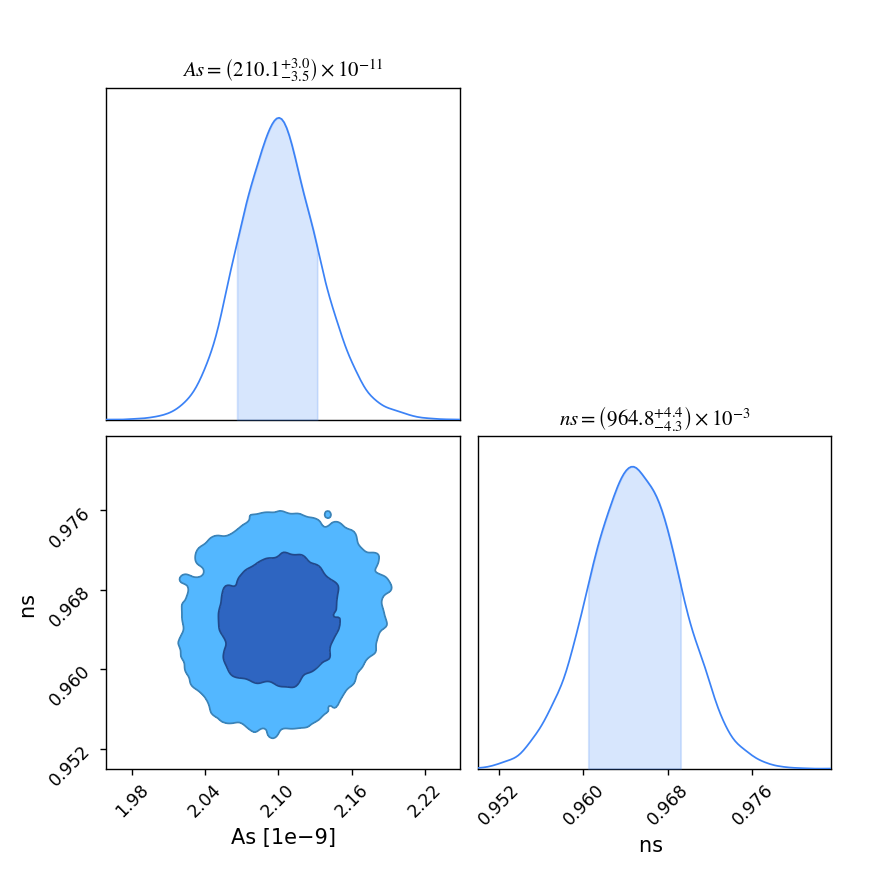

In [70]:
fig = c.plotter.plot()

#### minimizer

In [18]:
# folder = os.environ["CUP1D_PATH"] + "/data/minimize/Cabayol23_lres/"

# for ii in range(len(arr_drop_sim)):
#     for jj in range(len(arr_n_igm)):
#         samples = list_sims
#         values1 = dat[ii, jj, :, 0] * 1e8
#         err1 = np.sqrt(err[ii, jj, :, 0] * 1e8)
#         values2 = dat[ii, jj, :, 1]
#         err2 = np.sqrt(err[ii, jj, :, 1])
#         values3 = chi2[ii, jj, :]

#         fig, ax = plt.subplots(1, 3, sharey=True, figsize=(5, 10))

#         # Create a scatter plot with two points for each sample
#         ax[0].errorbar(
#             values1, samples, yerr=None, xerr=err1, ls="", marker="o"
#         )
#         #         ax[0].scatter(values1, samples, marker="o", color="r")
#         ax[1].errorbar(
#             values2, samples, yerr=None, xerr=err2, ls="", marker="o"
#         )

#         #         ax[1].scatter(values2, samples)
#         ax[2].scatter(values3, samples)
#         lvls = [-0.05, 0, 0.05]
#         lss = [":", "--", ":"]
#         for ls, lvl in zip(lss, lvls):
#             ax[0].axvline(lvl, ls=ls, color="k")
#             ax[1].axvline(lvl, ls=ls, color="k")
#         lvls = [1, 10, 100]
#         for lvl in lvls:
#             ax[2].axvline(lvl, ls="--", color="k")
#         ax[0].set_xlabel(r"$\Delta A_s \times 10^8$")
#         ax[1].set_xlabel(r"$\Delta n_s$")
#         ax[2].set_xlabel(r"$\chi^2$")
#         ax[2].set_xscale("log")
#         ax[0].set_xlim([-0.1, 0.1])
#         ax[1].set_xlim([-0.1, 0.1])
#         ax[2].set_xlim([0.1, 1e3])

#         if arr_drop_sim[ii]:
#             flag = "leave 1 out,"
#             flag2 = "yl1O"
#         else:
#             flag = "no leave 1 out,"
#             flag2 = "nl1O"

#         plt.suptitle(flag + " n_igm=" + str(arr_n_igm[jj]))
#         plt.tight_layout()
#         #         plt.savefig(folder + flag2 + "nigm" + str(arr_n_igm[jj]) + ".png")
#         break
#     break

### sampler

#### difference

<IPython.core.display.Javascript object>


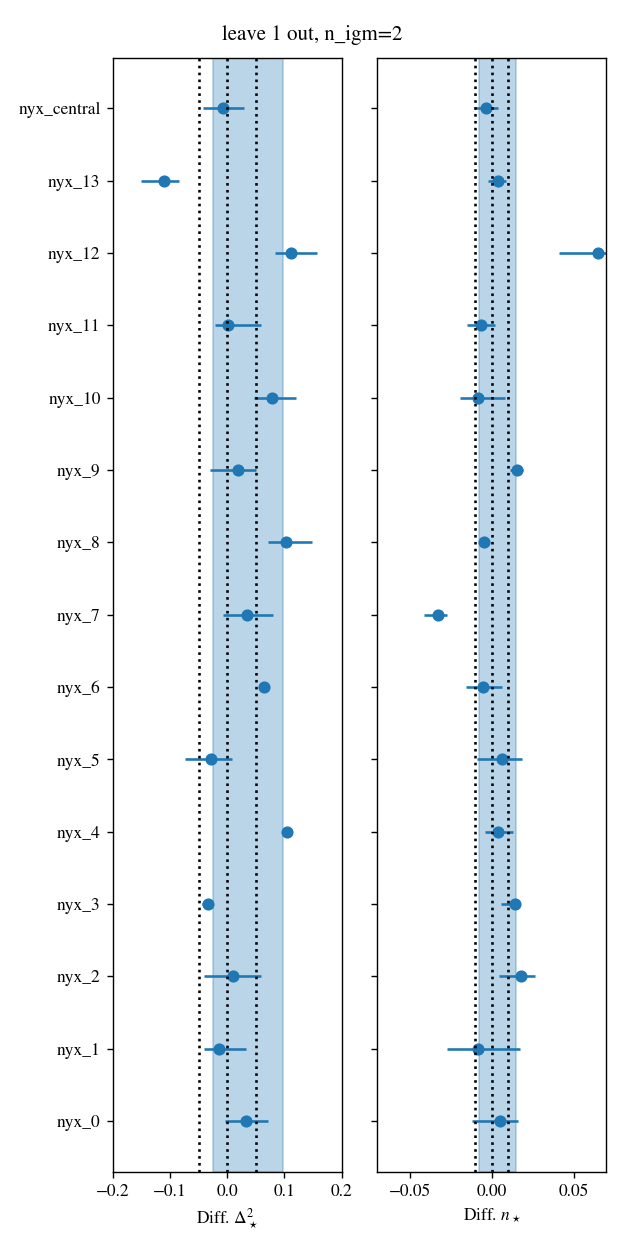

In [19]:
folder = (
    os.path.dirname(os.environ["CUP1D_PATH"])
    + "/data/cup1d/sampler/"
    + training_set
)

vlines = np.array([[0.0, 0.05, -0.05], [0.0, 0.01, -0.01]])

mask = []
for sim in archive.list_sim:
    if (sim in sim_avoid) | (sim in archive.list_sim_test[1:]):
        mask.append(False)
    else:
        mask.append(True)

if add_hires:
    folder += "_hres/"
else:
    folder += "_lres/"
folder += "figs/"

lab_par_use = []
for par in par_use:
    lab_par_use.append("Diff. " + par)

for ii in range(len(arr_drop_sim)):
    for jj in range(len(arr_n_igm)):
        samples = np.array(list_sims)[mask]

        fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 10))

        # Create a scatter plot with two points for each sample
        for kk in range(2):
            values = diff_dat[ii, jj, mask, kk]
            xerr = diff_errdat[ii, jj, mask, kk, :].T

            ax[kk].plot(
                values,
                samples,
                ls="",
                color="C0",
                marker="o",
            )
            ax[kk].errorbar(
                values,
                samples,
                xerr=xerr,
                color="C0",
                ls="",
            )
            std_values = np.percentile(values, [16, 84])
            ax[kk].axvspan(std_values[0], std_values[1], alpha=0.3, color="C0")
            #             ax[kk].scatter(values, samples, marker="o", color="r")
            ax[kk].set_xlabel(lab_par_use[kk])
            if kk == 0:
                ax[kk].set_xlim([-0.2, 0.2])
            else:
                ax[kk].set_xlim([-0.07, 0.07])

            for uu in range(vlines.shape[1]):
                ax[kk].axvline(vlines[kk, uu], ls=":", color="k")

        if arr_drop_sim[ii]:
            flag = "leave 1 out,"
            flag2 = "flag2_yl1O"
        else:
            flag = "no leave 1 out,"
            flag2 = "flag2_nl1O"

        plt.suptitle(flag + " n_igm=" + str(arr_n_igm[jj]))
        plt.tight_layout()
        plt.savefig(
            folder + "png/" + flag2 + "_nigm" + str(arr_n_igm[jj]) + ".png"
        )
        plt.savefig(
            folder + "pdf/" + flag2 + "_nigm" + str(arr_n_igm[jj]) + ".pdf"
        )
#         break
#     break

#### rel difference

<IPython.core.display.Javascript object>


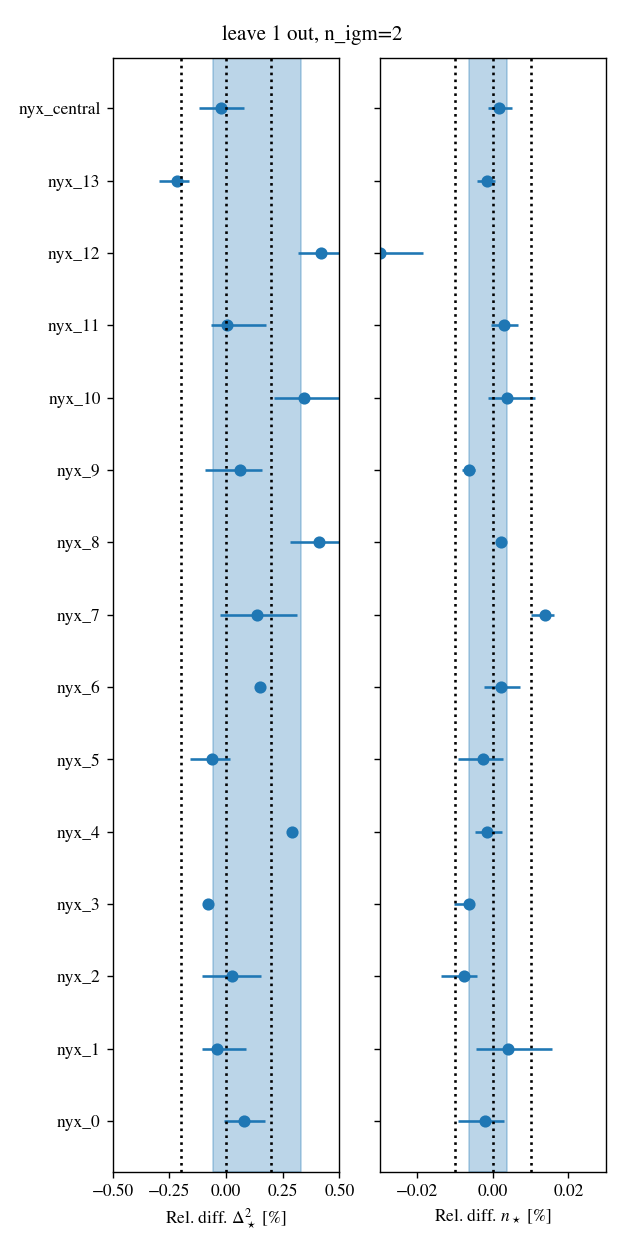

In [20]:
folder = (
    os.path.dirname(os.environ["CUP1D_PATH"])
    + "/data/cup1d/sampler/"
    + training_set
)

vlines = np.array([[0.0, 0.2, -0.2], [0.0, 0.01, -0.01]])

mask = []
for sim in archive.list_sim:
    if (sim in sim_avoid) | (sim in archive.list_sim_test[1:]):
        mask.append(False)
    else:
        mask.append(True)

if add_hires:
    folder += "_hres/"
else:
    folder += "_lres/"
folder += "figs/"

lab_par_use = []
for par in par_use:
    lab_par_use.append("Rel. diff. " + par + " [%]")

for ii in range(len(arr_drop_sim)):
    for jj in range(len(arr_n_igm)):
        samples = np.array(list_sims)[mask]

        fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 10))

        # Create a scatter plot with two points for each sample
        for kk in range(2):
            values = rel_dat[ii, jj, mask, kk]
            xerr = rel_errdat[ii, jj, mask, kk, :].T

            ax[kk].plot(
                values,
                samples,
                ls="",
                color="C0",
                marker="o",
            )
            ax[kk].errorbar(
                values,
                samples,
                xerr=xerr,
                color="C0",
                ls="",
            )
            std_values = np.percentile(values, [16, 84])
            ax[kk].axvspan(std_values[0], std_values[1], alpha=0.3, color="C0")
            #             ax[kk].scatter(values, samples, marker="o", color="r")
            ax[kk].set_xlabel(lab_par_use[kk])
            if kk == 0:
                ax[kk].set_xlim([-0.5, 0.5])
            else:
                ax[kk].set_xlim([-0.03, 0.03])

            for uu in range(vlines.shape[1]):
                ax[kk].axvline(vlines[kk, uu], ls=":", color="k")

        if arr_drop_sim[ii]:
            flag = "leave 1 out,"
            flag2 = "flag2_yl1O"
        else:
            flag = "no leave 1 out,"
            flag2 = "flag2_nl1O"

        plt.suptitle(flag + " n_igm=" + str(arr_n_igm[jj]))
        plt.tight_layout()
        plt.savefig(
            folder + "png/rel_" + flag2 + "_nigm" + str(arr_n_igm[jj]) + ".png"
        )
        plt.savefig(
            folder + "pdf/rel_" + flag2 + "_nigm" + str(arr_n_igm[jj]) + ".pdf"
        )
# #         break
# #     break

### rel diff extra sims

<IPython.core.display.Javascript object>


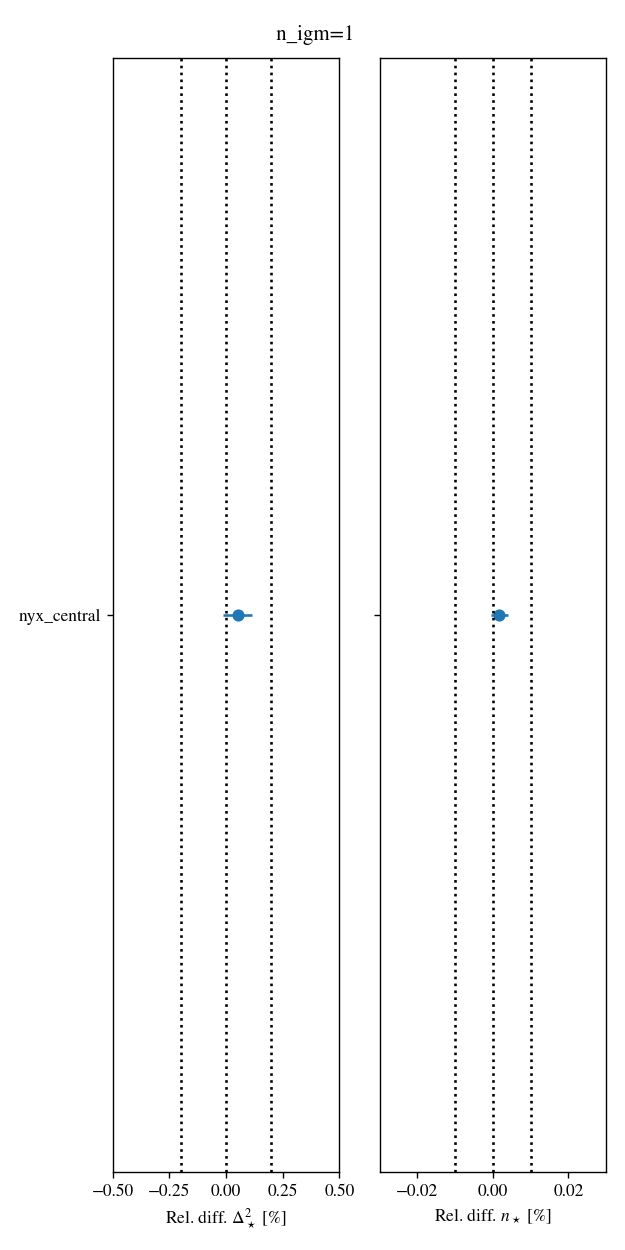

In [11]:
folder = (
    os.path.dirname(os.environ["CUP1D_PATH"])
    + "/data/cup1d/sampler/"
    + training_set
)

vlines = np.array([[0.0, 0.2, -0.2], [0.0, 0.01, -0.01]])

mask = []
for sim in archive.list_sim:
    if (sim in sim_avoid) | (sim in archive.list_sim_cube):
        mask.append(False)
    else:
        mask.append(True)

if add_hires:
    folder += "_hres/"
else:
    folder += "_lres/"
folder += "figs/"

lab_par_use = []
for par in par_use:
    lab_par_use.append("Rel. diff. " + par + " [%]")

for ii in range(len(arr_drop_sim)):
    for jj in range(len(arr_n_igm)):
        samples = np.array(list_sims)[mask]

        fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 10))

        # Create a scatter plot with two points for each sample
        for kk in range(2):
            values = rel_dat[ii, jj, mask, kk]
            xerr = rel_errdat[ii, jj, mask, kk, :].T

            ax[kk].plot(
                values,
                samples,
                ls="",
                color="C0",
                marker="o",
            )
            ax[kk].errorbar(
                values,
                samples,
                xerr=xerr,
                color="C0",
                ls="",
            )
            #             std_values = np.percentile(values, [16, 84])
            #             ax[kk].axvspan(std_values[0], std_values[1], alpha=0.3, color="C0")
            #             ax[kk].scatter(values, samples, marker="o", color="r")
            ax[kk].set_xlabel(lab_par_use[kk])
            if kk == 0:
                ax[kk].set_xlim([-0.5, 0.5])
            else:
                ax[kk].set_xlim([-0.03, 0.03])

            for uu in range(vlines.shape[1]):
                ax[kk].axvline(vlines[kk, uu], ls=":", color="k")

        if arr_drop_sim[ii]:
            flag = ""
            flag2 = "flag2_yl1O"
        else:
            flag = ""
            flag2 = "flag2_nl1O"

        plt.suptitle(flag + " n_igm=" + str(arr_n_igm[jj]))
        plt.tight_layout()
        plt.savefig(
            folder
            + "png/rel_"
            + flag2
            + "_nigm"
            + str(arr_n_igm[jj])
            + "_especial.png"
        )
        plt.savefig(
            folder
            + "pdf/rel_"
            + flag2
            + "_nigm"
            + str(arr_n_igm[jj])
            + "_especial.pdf"
        )
# #         break
# #     break

#### both

<IPython.core.display.Javascript object>


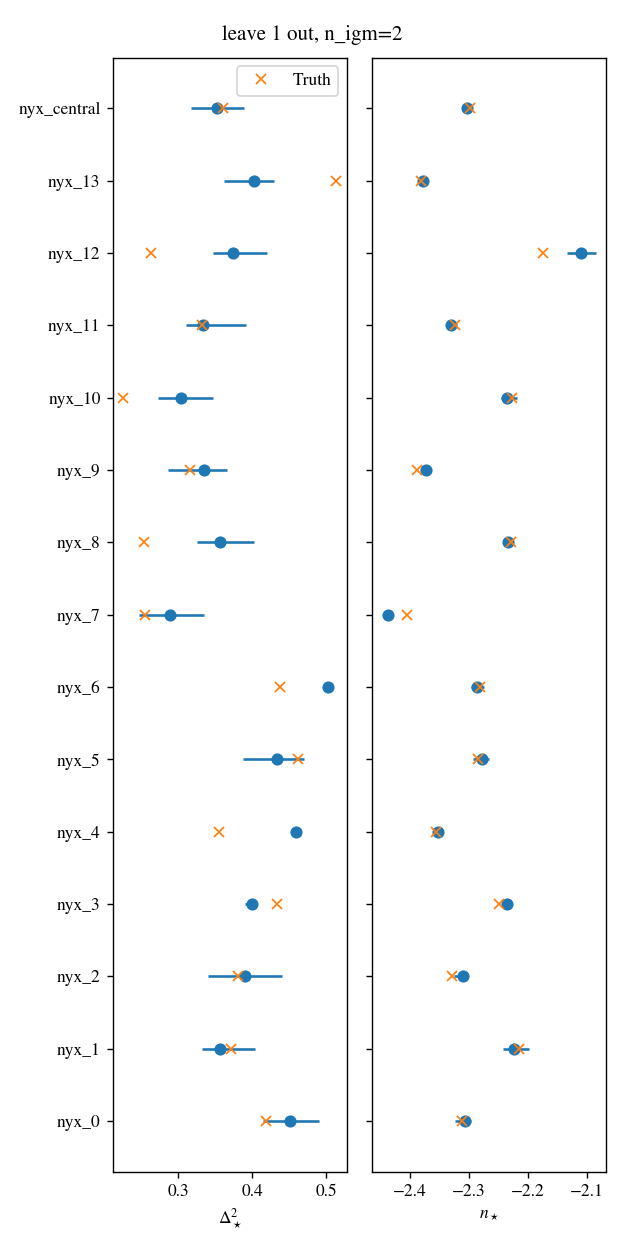

In [21]:
folder = (
    os.path.dirname(os.environ["CUP1D_PATH"])
    + "/data/cup1d/sampler/"
    + training_set
)

vlines = np.array([[0.0, 0.05, -0.05], [0.0, 0.01, -0.01]])


mask = []
for sim in archive.list_sim:
    if (sim in sim_avoid) | (sim in archive.list_sim_test[1:]):
        mask.append(False)
    else:
        mask.append(True)

if add_hires:
    folder += "_hres/"
else:
    folder += "_lres/"
folder += "figs/"

lab_par_use = []
for par in par_use:
    lab_par_use.append(par)

for ii in range(len(arr_drop_sim)):
    for jj in range(len(arr_n_igm)):
        samples = np.array(list_sims)[mask]

        fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 10))

        # Create a scatter plot with two points for each sample
        par_labs = ["Delta2_star", "n_star"]
        for kk in range(2):
            if kk == 0:
                label0 = "Model"
                label1 = "Truth"
            else:
                label0 = None
                label1 = None

            values = diff_dat[ii, jj, mask, kk] + fid_cosmo[par_labs[kk]][mask]
            xerr = diff_errdat[ii, jj, mask, kk, :].T

            ax[kk].plot(
                values,
                samples,
                ls="",
                color="C0",
                marker="o",
            )
            ax[kk].errorbar(
                values,
                samples,
                xerr=xerr,
                color="C0",
                ls="",
            )

            ax[kk].plot(
                fid_cosmo[par_labs[kk]][mask],
                samples,
                ls="",
                color="C1",
                marker="x",
                label=label1,
            )

            ax[kk].set_xlabel(lab_par_use[kk])
            if kk == 0:
                ax[kk].legend()
            #             if kk == 0:
            #                 ax[kk].set_xlim([-0.2, 0.2])
            #             else:
            #                 ax[kk].set_xlim([-0.07, 0.07])

        #             for uu in range(vlines.shape[1]):
        #                 ax[kk].axvline(vlines[kk, uu], ls=":", color="k")

        if arr_drop_sim[ii]:
            flag = "leave 1 out,"
            flag2 = "flag2_yl1O"
        else:
            flag = "no leave 1 out,"
            flag2 = "flag2_nl1O"

        plt.suptitle(flag + " n_igm=" + str(arr_n_igm[jj]))
        plt.tight_layout()
        plt.savefig(
            folder
            + "png/both_"
            + flag2
            + "_nigm"
            + str(arr_n_igm[jj])
            + ".png"
        )
        plt.savefig(
            folder
            + "pdf/both_"
            + flag2
            + "_nigm"
            + str(arr_n_igm[jj])
            + ".pdf"
        )
#         break
#     break